In [15]:
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import lightning


class Encoder(torch.nn.Sequential):
    def __init__(self, lenght, input_dim, encoded_dim, hidden_dim=512):
        super().__init__(
            torch.nn.Flatten(),
            torch.nn.Linear(2*lenght*input_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, encoded_dim),
        )

class Decoder(torch.nn.Sequential):
    def __init__(self, lenght, input_dim, encoded_dim, hidden_dim=512):
        super().__init__(
            torch.nn.Linear(encoded_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_dim, 2*lenght*input_dim),
            torch.nn.Unflatten(1, (lenght, input_dim, 2)),
        )


class Autoencoder(lightning.LightningModule):
    def __init__(self, lenght, input_dim, encoded_dim, hidden_dim=512):
        super().__init__()
        self.encoder = Encoder(lenght, input_dim, encoded_dim, hidden_dim)
        self.decoder = Decoder(lenght, input_dim, encoded_dim, hidden_dim)
        self.loss = torch.nn.MSELoss()

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def forward(self, x):
        x = torch.concat([torch.nan_to_num(x), torch.isnan(x)], dim=-1)
        return self.decoder(self.encoder(x))

    def training_step(self, x, batch_idx):
        x = torch.concat([torch.nan_to_num(x), torch.isnan(x)], dim=-1)
        h = self.encoder(x)
        x_hat = self.decoder(h).reshape(x.shape)    
        loss = self.loss(x_hat, x)
        self.log("train_loss", loss, prog_bar=True)
        return loss

In [16]:
class GapDataset(Dataset):
    def __init__(self, time_lenght=2**13, dataset_size=100*2**10):
        self.time_lenght = time_lenght
        self.dataset_size = dataset_size

    def __len__(self):
        return self.dataset_size

    def A_gen(self):
        return np.random.uniform(0, 5)

    def om_gen(self):
        return np.random.uniform(2**-12, 2**-6)

    def phi_gen(self):
        return np.random.uniform(0, 2 * np.pi)

    def pars_gen(self):
        return self.A_gen(), self.om_gen(), self.phi_gen()

    def signal_clean_gen(self, time_lenght=2**13):
        A, om, phi = self.pars_gen()
        times = np.arange(time_lenght)
        data = A * np.sin(om * times + phi)
        return data[:, None]

    def noise_gen(self, time_lenght=2**13):
        return np.random.random(size=(time_lenght, 1))

    def mask_gen(
        self, 
        time_lenght=2**13,
        mean_num_gaps=3,
        mean_lenght_gaps=2**10,
        scal_lenght_gaps=2**8,
    ):
        ngaps = mean_num_gaps + int(2 * np.random.random())
        mask = np.zeros(time_lenght)
        for _ in range(ngaps):
            g_min = int(np.random.uniform(0, time_lenght))
            g_max = min(
                g_min
                + int(
                    np.abs(np.random.normal(loc=mean_lenght_gaps, scale=scal_lenght_gaps))
                ),
                time_lenght,
            )
            mask[g_min:g_max] = np.nan

        return mask[:, None]

    def __getitem__(self, idx):
        return (
            self.signal_clean_gen(time_lenght=self.time_lenght)
            + self.noise_gen(time_lenght=self.time_lenght)
            + self.mask_gen(time_lenght=self.time_lenght)
        ).astype(np.float32)

torch.Size([64, 8192, 1, 2])



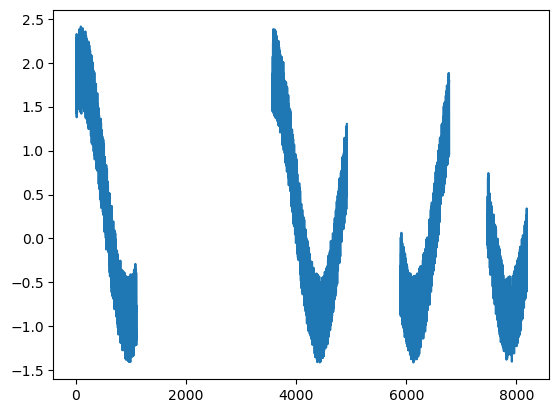

In [17]:
dataset = GapDataset()
dataloader = DataLoader(dataset, batch_size=64)

model = Autoencoder(dataset.time_lenght, 1, encoded_dim=64)
for x in dataloader:
    y = model(x)
    print(y.shape)
    plt.plot(np.arange(2**13), x[0])
    print()
    break

In [18]:
import lightning.pytorch
from lightning.pytorch import loggers


logger = loggers.CometLogger()
trainer = lightning.Trainer(
    devices="2,",
    max_time="00:01:00:00",
    logger=logger,
)
model = Autoencoder(dataset.time_lenght, 1, 64)
trainer.fit(model, dataloader)

CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
COMET INFO: Experiment is live on comet.com https://www.comet.com/davidesartor/general/89f2e44625f949df93e42d2eaa6f14e1

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 8.9 M 
1 | decoder | Decoder | 9.0 M 
2 | loss    | MSELoss | 0  

Training: |          | 0/? [00:00<?, ?it/s]

/home/davide_sartor/.conda/envs/torch_env/lib/python3.12/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : autonomous_hoverfly_2440
COMET INFO:     url                   : https://www.comet.com/davidesartor/general/89f2e44625f949df93e42d2eaa6f14e1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     train_loss [238] : (0.1114000529050827, 1.4082419872283936)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     git metadata        : 1
COMET INFO:     

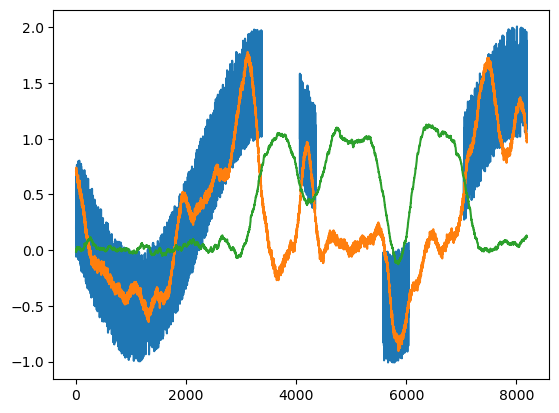

In [42]:
model = model.cpu()
for x in dataloader:
    y = model(x).detach().numpy()
    x_hat, mask = y[0, :, :, 0], y[0, :, :, 1]
    plt.plot(np.arange(2**13), x[0])
    plt.plot(np.arange(2**13), x_hat)
    plt.plot(np.arange(2**13), mask)
    print()
    break